# Predicting Breast Cancer in Wisconsin

This data set was donated by the University of Wisconsin Hospitals. We have diagnostic data about patients under the care of Dr. William Wolberg and whether masses found were malignant or benign. 

We will explore the data to understand the most significant identifying attributes of patients with malignant masses to give us a starting point for future research how to prevent malignant masses. We will create a model to predict malignant masses based on the diagnositic data provided.


In [11]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math
import seaborn as sns
import sklearn
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix
from sklearn import ensemble
from sklearn import tree
from sklearn.svm import SVC
%matplotlib inline
sns.set_style('white')

In [2]:
data = pd.read_csv('breast-cancer-wisconsin.csv', header=None)

In [3]:
#Give data names based on the text document
data.columns=['Sample_id','Clump_thick','Uni_cell_size','Uni_cell_shape'
             ,'Marg_adhesion','Epi_cell_size','Nuclei_bare','Chromatin_bland'
             ,'Nucleoli_norm','Mitoses','Class']

In [4]:
#Make class binary 0,1 field. 1 is malignant (cancer), 0 is benign 
data.Class = (data.Class/2 -1).astype(int)

In [80]:
#Replace question marks with NaN and remove them
count = 0
for col in data.columns:
    for item in data[col].iteritems():
        if item[1] == '?':
            data[col].loc[item[0]] = np.NAN
#16 rows in Nuclei_bare have ?, getting rid of them would be only 2% of our data.            
data = data.dropna()

#Droping Sample ID as it is simply an identifier and isn't additive
data = data.drop(columns=['Sample_id'])

In [81]:
#Setting up variables
X = data.drop(columns=['Class'])
y = data.Class

In [82]:
#Data is chronilogical, so need to split up data randomly
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

In [83]:
#Trying linear regression, even though data is categorical
olr_init = linear_model.LinearRegression()
olr_init.fit(X_train, y_train)
olr_init_cvs = cross_val_score(olr_init, X_train, y_train, cv=10)

In [84]:
#Initial model with Decision Tree Classifier
dt_init = tree.DecisionTreeClassifier(criterion='entropy',
                                      max_depth=5)
dt_init.fit(X_train, y_train)
dt_init_cvs = cross_val_score(dt_init, X_train, y_train, cv=10)

In [85]:
#Initial model with Logistic Regression
lr_init = LogisticRegression()
lr_init.fit(X_train,y_train)
lr_init_cvs = cross_val_score(lr_init, X_train, y_train, cv=10)

In [86]:
#Initial model with Support Vector Classifer
svc_init = SVC()
svc_init.fit(X_train, y_train)
svc_init_cvs = cross_val_score(svc_init, X_train, y_train, cv=10)

In [109]:
#Initial model with K-Nearest Neighbors
knn_init = KNeighborsClassifier(n_neighbors=7)
knn_init.fit(X_train,y_train)
knn_init_cvs = cross_val_score(knn_init, X_train, y_train, cv=10)

In [88]:
#Initial model with Naive Bayes
bnb_init = BernoulliNB()
bnb_init.fit(X_train,y_train)
bnb_init_cvs = cross_val_score(bnb_init, X_train, y_train, cv=10)

In [89]:
#Initial model with Random Forest Classifier
rfc_init = ensemble.RandomForestClassifier(n_estimators=10,
                                           criterion='entropy',
                                           max_depth=4)
rfc_init.fit(X_train, y_train)
rfc_init_cvs = cross_val_score(rfc_init, X_train, y_train, cv=10)

In [90]:
#Create Initial Model DataFrame
init_models = pd.DataFrame({'RFC': rfc_init_cvs,
                            'DT': dt_init_cvs,
                            'LR': lr_init_cvs,
                            'KNN': knn_init_cvs,
                            'BNB': bnb_init_cvs, 
                            'OLR': olr_init_cvs,
                            'SVC': svc_init_cvs})

In [91]:
#Means and standard deviations for classifiers
def get_desc(model):
    for col in model.columns:
        if len(str(col)) == 2:
            print(str(col),' : {0:.3f}'.format(model[col].mean())+'({0:.3f})'.format(
                np.std(model[col])))
        else:
            print(str(col),': {0:.3f}'.format(model[col].mean())+
                  '({0:.3f})'.format(np.std(model[col])))
            
get_desc(init_models)

BNB : 0.659(0.005)
DT  : 0.941(0.036)
KNN : 0.977(0.017)
LR  : 0.968(0.024)
OLR : 0.837(0.041)
RFC : 0.977(0.022)
SVC : 0.958(0.030)


In [99]:
#Check correct prediction of malignant tumors for high performing (>0.9) models

def true_pred(model):
    cm = confusion_matrix(model.predict(X_train), y_train)
    print('We correctly predicted malignant masses {0:.2f}% of the time.'.format(
        (cm[1][1])/sum(cm[1])*100))

#Decision Tree
true_pred(dt_init)

#K-Nearest Neighbors
true_pred(knn_init)

#Logistic Regression
true_pred(lr_init)

#Random Forest
true_pred(rfc_init)

#Support Vector
true_pred(svc_init)

#Support Vector is our highest performer

We correctly predicted malignant masses 95.88% of the time.
We correctly predicted malignant masses 96.95% of the time.
We correctly predicted malignant masses 96.91% of the time.
We correctly predicted malignant masses 95.88% of the time.
We correctly predicted malignant masses 99.39% of the time.


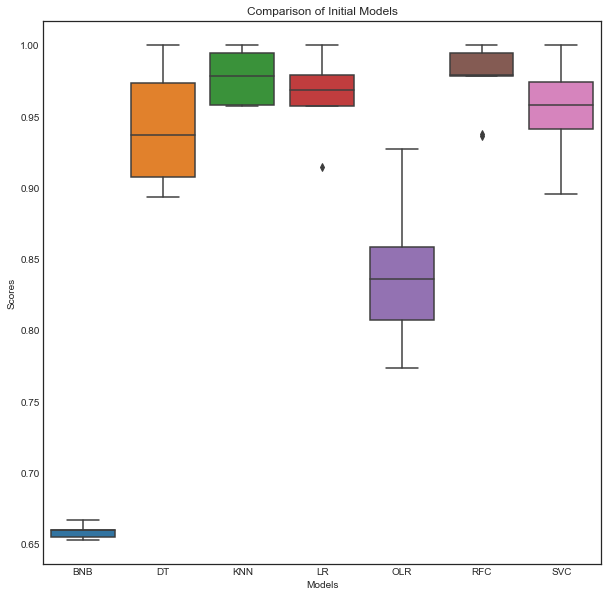

In [100]:
fig, ax = plt.subplots()
fig.set_size_inches(10,10)
im = sns.boxplot(data=init_models, ax=ax)
im.set_title('Comparison of Initial Models')
im.set_ylabel('Scores')
im.set_xlabel('Models')

plt.show()

In [101]:
#Dropping Naive Bayes and Linear Regression for poor performance and high variance
#Optimizing models using GridSearchCV
#Logisitic Regression will be our descriptive model

#Optimizing Random Forest
parameters = {}
parameters['criterion'] = ['entropy','gini']
parameters['max_depth'] = [3,4,5,6,7,8]
parameters['n_estimators'] = [5,10,20,30]

gsc_rfc = GridSearchCV(rfc_init, parameters, cv=3, verbose=1)
gsc_rfc.fit(X_train, y_train)
print(gsc_rfc.best_params_, gsc_rfc.best_score_)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
{'criterion': 'entropy', 'max_depth': 3, 'n_estimators': 30} 0.9832635983263598


[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed:    4.0s finished


In [102]:
#Optimized model with Random Forest Classifier
rfc_opt = ensemble.RandomForestClassifier(n_estimators=230,
                                           criterion='entropy',
                                           max_depth=3)
rfc_opt.fit(X_train, y_train)
rfc_opt_cvs = cross_val_score(rfc_opt, X_train, y_train, cv=10)

In [103]:
#Optimizing Decision Tree
parameters_dt = {}
parameters_dt['criterion'] = ['entropy','gini']
parameters_dt['max_depth'] = [3,4,5,6,7,8,10,20,30]

gsc_dt = GridSearchCV(dt_init, parameters_dt, cv=3, verbose=1)
gsc_dt.fit(X_train, y_train)
print(gsc_dt.best_params_, gsc_dt.best_score_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
{'criterion': 'entropy', 'max_depth': 3} 0.9623430962343096


[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:    0.2s finished


In [49]:
dt_opt = tree.DecisionTreeClassifier(criterion='entropy',
                                     max_depth=10)
dt_opt.fit(X_train, y_train)
dt_opt_cvs = cross_val_score(dt_opt, X_train, y_train, cv=10)

In [107]:
#Optimizing k-Nearest Neighbors
parameters_knn = {}
parameters_knn['n_neighbors'] = [5,10,15,20]
parameters_knn['leaf_size'] = [20,30,40,50]

gsc_knn = GridSearchCV(knn_init, parameters_knn, cv=3, verbose=1)
gsc_knn.fit(X_train, y_train)
print(gsc_knn.best_params_, gsc_knn.best_score_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
{'leaf_size': 20, 'n_neighbors': 5} 0.9728033472803347


[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    0.3s finished


In [108]:
knn_opt = KNeighborsClassifier(n_neighbors=5, leaf_size=20)
knn_opt.fit(X_train,y_train)
knn_opt_cvs = cross_val_score(knn_opt, X_train, y_train, cv=10)

In [112]:
#Optimizing Logistic Regression
parameters_lr = {}
parameters_lr['penalty'] = ['l2','l1']
parameters_lr['C'] = [0.001,0.01,0.1,1.0,10,100]

gsc_lr = GridSearchCV(lr_init, parameters_lr, cv=3, verbose=1)
gsc_lr.fit(X_train, y_train)
print(gsc_lr.best_params_, gsc_lr.best_score_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
{'C': 1.0, 'penalty': 'l1'} 0.9728033472803347


[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    0.2s finished


In [114]:
lr_opt = LogisticRegression(penalty='l1', C=1.0)
lr_opt.fit(X_train,y_train)
lr_opt_cvs = cross_val_score(lr_opt, X_train, y_train, cv=10)

In [134]:
#Optimizing Support Vector
parameters_svc = {}
parameters_svc['C'] = [1,2,3,4,5]

gsc_svc = GridSearchCV(svc_init, parameters_svc, cv=10, verbose=1)
gsc_svc.fit(X_train, y_train)
print(gsc_svc.best_params_, gsc_svc.best_score_)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
{'C': 2} 0.9623430962343096


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.4s finished


In [135]:
svc_opt = SVC(C=2)
svc_opt.fit(X_train, y_train)
svc_opt_cvs = cross_val_score(svc_opt, X_train, y_train, cv=10)

In [136]:
opt_models = pd.DataFrame({'RFC': rfc_opt_cvs,
                           'DT': dt_opt_cvs,
                           'LR': lr_opt_cvs,
                           'KNN': knn_opt_cvs,
                           'SVC': svc_opt_cvs})

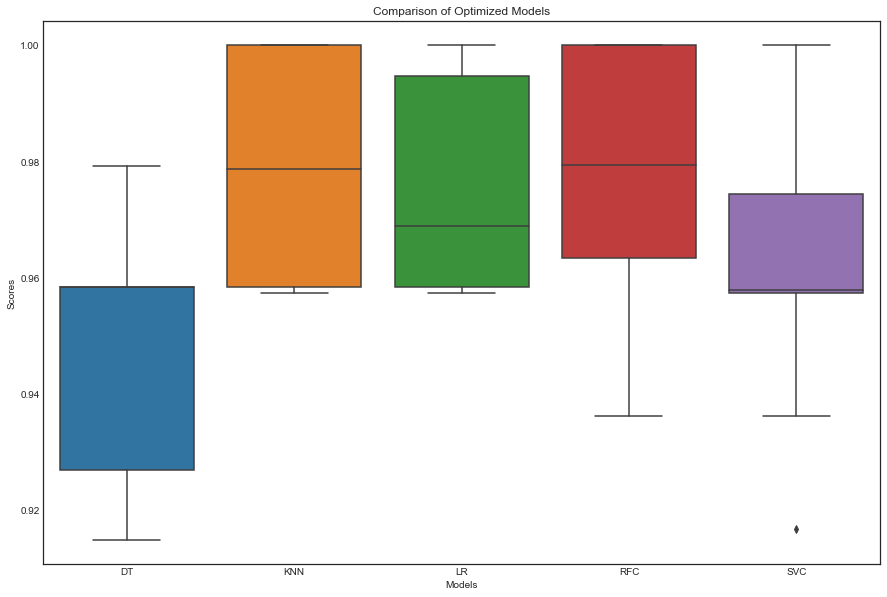

In [138]:
fig, ax = plt.subplots()
fig.set_size_inches(15,10)
im = sns.boxplot(data=opt_models, ax=ax)
im.set_title('Comparison of Optimized Models')
im.set_ylabel('Scores')
im.set_xlabel('Models')

plt.show()

In [140]:
#We will eliminate Decision Tree, due to lowest performance and duplication with RFC
#Models are performing very strongly, but how do they do with predicting desired outcome?

#K-Nearest Neighbors
true_pred(knn_opt)

#Logistic Regression
true_pred(lr_opt)

#Random Forest
true_pred(rfc_opt)

#Support Vector
true_pred(svc_opt)

We correctly predicted malignant masses 97.55% of the time.
We correctly predicted malignant masses 96.93% of the time.
We correctly predicted malignant masses 95.88% of the time.
We correctly predicted malignant masses 100.00% of the time.


In [57]:
#We will run final test data with both Decision Tree and Random Forest
#Decision Tree
dt_final = tree.DecisionTreeClassifier(criterion='entropy',
                                     max_depth=10)
dt_final.fit(X_test, y_test)
dt_final_cvs = cross_val_score(dt_final, X_test, y_test, cv=10)

#Random Forest
rfc_final = ensemble.RandomForestClassifier(n_estimators=20,
                                           criterion='entropy',
                                           max_depth=3)
rfc_final.fit(X_test, y_test)
rfc_final_cvs = cross_val_score(rfc_final, X_test, y_test, cv=10)

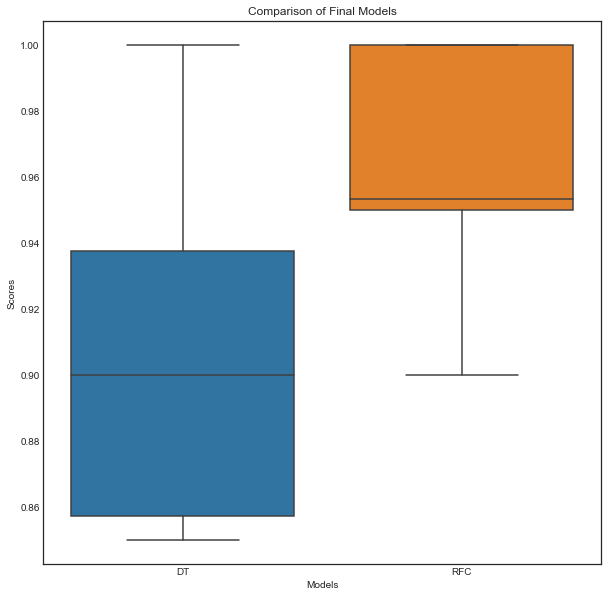

In [62]:
final_models = pd.DataFrame({'DT': dt_final_cvs,
                             'RFC': rfc_final_cvs})

fig, ax = plt.subplots()
fig.set_size_inches(10,10)
im = sns.boxplot(data=final_models, ax=ax)
im.set_title('Comparison of Final Models')
im.set_ylabel('Scores')
im.set_xlabel('Models')

plt.show()

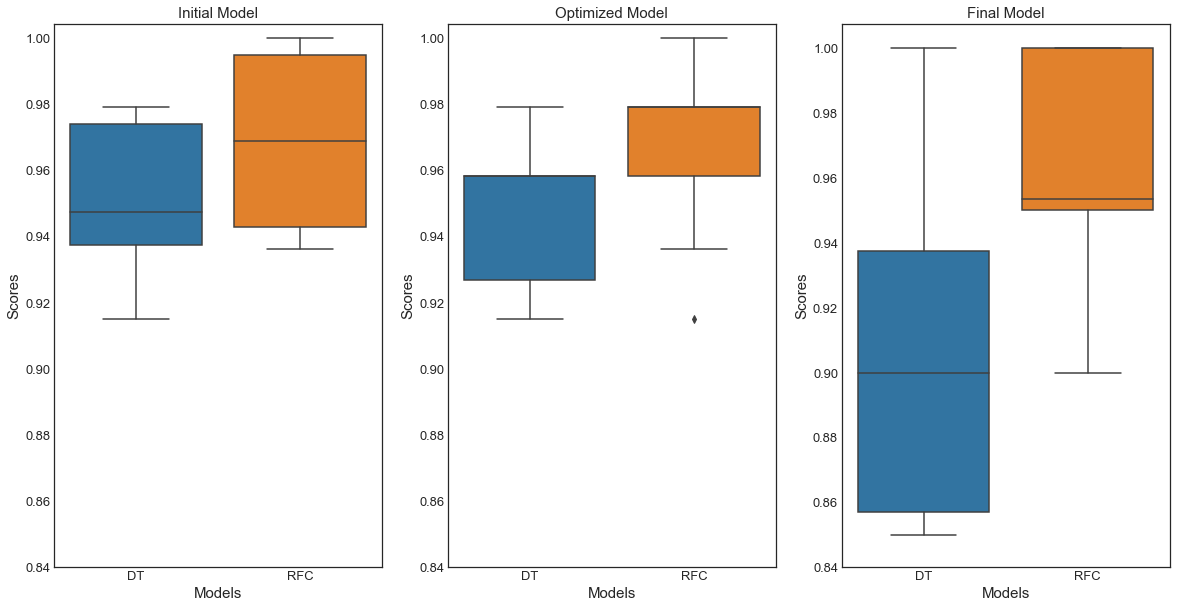

In [73]:
fig = plt.figure(figsize=(20, 10))
#fig.subplots_adjust(hspace=0.5, wspace=0.5)


plt.subplot(1,3,3)
im = sns.boxplot(data=final_models)
im.set_title('Final Model', fontsize=15)
im.set_ylabel('Scores', fontsize=15)
im.set_xlabel('Models', fontsize=15)
plt.yticks([0.84,0.86,0.88,0.90,0.92,0.94,0.96,0.98,1.00], fontsize=13)
plt.xticks(fontsize=13)


plt.subplot(1,3,2)
im = sns.boxplot(data=opt_models.loc[:,['DT','RFC']])
im.set_title('Optimized Model', fontsize=15)
im.set_ylabel('Scores', fontsize=15)
im.set_xlabel('Models', fontsize=15)
plt.yticks([0.84,0.86,0.88,0.90,0.92,0.94,0.96,0.98,1.00], fontsize=13)
plt.xticks(fontsize=13)

plt.subplot(1,3,1)
im = sns.boxplot(data=init_model2)
im.set_title('Initial Model', fontsize=15)
im.set_ylabel('Scores', fontsize=15)
im.set_xlabel('Models', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks([0.84,0.86,0.88,0.90,0.92,0.94,0.96,0.98,1.00], fontsize=13)

plt.show()
fig.savefig('Model_Comparison.png')

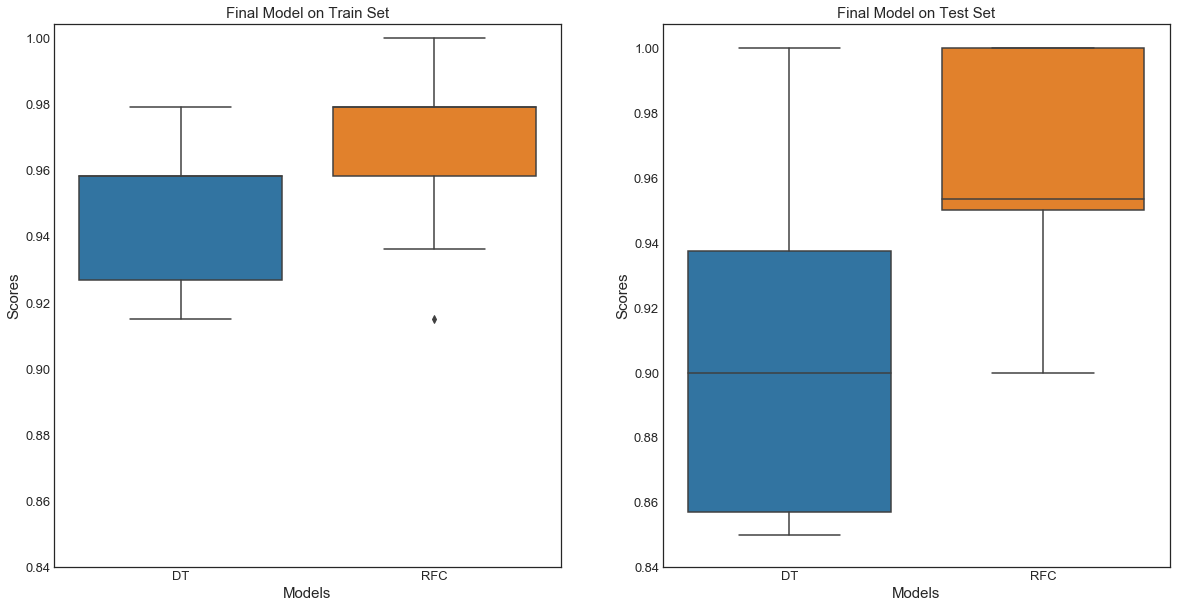

In [77]:
#Final on Test vs Final on Train Datasets
fig = plt.figure(figsize=(20, 10))
#fig.subplots_adjust(hspace=0.5, wspace=0.5)

plt.subplot(1,2,2)
im = sns.boxplot(data=final_models)
im.set_title('Final Model on Test Set', fontsize=15)
im.set_ylabel('Scores', fontsize=15)
im.set_xlabel('Models', fontsize=15)
plt.yticks([0.84,0.86,0.88,0.90,0.92,0.94,0.96,0.98,1.00], fontsize=13)
plt.xticks(fontsize=13)

plt.subplot(1,2,1)
im = sns.boxplot(data=opt_models.loc[:,['DT','RFC']])
im.set_title('Final Model on Train Set', fontsize=15)
im.set_ylabel('Scores', fontsize=15)
im.set_xlabel('Models', fontsize=15)
plt.yticks([0.84,0.86,0.88,0.90,0.92,0.94,0.96,0.98,1.00], fontsize=13)
plt.xticks(fontsize=13)

plt.show()
fig.savefig('TestvTrain_Finalmodel.png')

In [79]:
print(X_train.columns)
print(olr_init.coef_)
#From Coefficients, we can see best correlations were with Clump Thickness, Uniformity
#Cell Size, and Nuclei Bare

Index(['Sample_id', 'Clump_thick', 'Uni_cell_size', 'Uni_cell_shape',
       'Marg_adhesion', 'Epi_cell_size', 'Nuclei_bare', 'Chromatin_bland',
       'Nucleoli_norm', 'Mitoses'],
      dtype='object')
[-6.54473002e-10  3.38981096e-02  3.18490356e-02  7.74918291e-03
  7.26237227e-03 -6.07200586e-04  4.80887073e-02  1.80372652e-02
  1.90916484e-02  4.88221357e-03]


[-6.54473002e-10  3.38981096e-02  3.18490356e-02  7.74918291e-03
  7.26237227e-03 -6.07200586e-04  4.80887073e-02  1.80372652e-02
  1.90916484e-02  4.88221357e-03]


In [46]:
rfe = RFE(olr, 3)
rfe.fit(X_train, y_train)
rfe.ranking_

NameError: name 'RFE' is not defined

In [47]:
#Most important features for determining cancer are Clump Thickness, Uniformity Cell Shape,
#and Bare Nuclei